## Offensive Language Identification

This is the task 'a' in Task 6: OffensEval: Identifying and Categorizing Offensive Language in Social Media in SemEval 2019. We have explored how a capsule network can be used in Offensive language identification. 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import os
import time
import gc
import re
from unidecode import unidecode

Using TensorFlow backend.


### Loading the training and testing files

In [2]:
train = pd.read_csv("Data/training/offenseval-training-v1.tsv", sep='\t')

test_tweets = pd.read_csv("Data/testing/testset-taska.tsv", sep='\t')
test_labels = pd.read_csv("Data/testing/labels-test-a.csv", header=-1, names = ["id", "subtask_a"])

test = pd.merge(test_tweets, test_labels, on=['id','id'])
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (13240, 5)
Test shape :  (860, 3)


Changing case of the tweets to lower case, since the embedding model only has lower case words

In [3]:
train["tweet"] = train["tweet"].str.lower()
test["tweet"] = test["tweet"].str.lower()

cleaning the puncutation marks

In [4]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):

    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


train["tweet"] = train["tweet"].apply(lambda x: clean_text(x))
test["tweet"] = test["tweet"].apply(lambda x: clean_text(x))

In [5]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = 72 # max number of words in a question to use #99.99%

## fill up the missing values
X = train["tweet"].fillna("_na_").values
X_test = test["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
X = pad_sequences(X, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

## Get the target values
Y = train['subtask_a'].values
Y

array(['OFF', 'OFF', 'NOT', ..., 'OFF', 'OFF', 'NOT'], dtype=object)

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(Y)
encoded_Y = le.transform(Y)
encoded_Y

array([1, 1, 0, ..., 1, 1, 0])

Building the Embedding matrix

In [7]:
word_index = tokenizer.word_index
max_features = len(word_index)+1
def load_glove(word_index):
    EMBEDDING_FILE = '/data/glove/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = '/data/fasttext/crawl-300d-2M-subword.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

Only Glove vectors have been used in embedding matrix. Can explore it further in future

In [8]:
embedding_matrix = load_glove(word_index)

Definning the Capsule Layer in Keras

In [9]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

In [11]:
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
            
    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

Capsule Layer with a Bi directional GRU. Architecture found in text classification project.

In [12]:
def capsule():
    K.clear_session()       
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(rate=0.2)(x)
    x = Bidirectional(GRU(100, return_sequences=True, 
                                kernel_initializer=glorot_normal(seed=12300), recurrent_initializer=orthogonal(gain=1.0, seed=10000)))(x)

    x = Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(x)
    x = Flatten()(x)

    x = Dense(100, activation="relu", kernel_initializer=glorot_normal(seed=12300))(x)
    x = Dropout(0.12)(x)
    x = BatchNormalization()(x)

    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(),)
    return model

In [13]:
def f1_smart(y_true, y_pred):
    args = np.argsort(y_pred)
    tp = y_true.sum()
    fs = (tp - np.cumsum(y_true[args[:-1]])) / np.arange(y_true.shape[0] + tp - 1, tp, -1)
    res_idx = np.argmax(fs)
    return 2 * fs[res_idx], (y_pred[args[res_idx]] + y_pred[args[res_idx + 1]]) / 2

Training with early stopping and reducing learning rate on plateu. In each fold values for the test set is also predicted, And after the process, predicted values for the test file would be mean from each fold

In [14]:
kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
bestscore = []
y_test = np.zeros((X_test.shape[0], ))
for i, (train_index, valid_index) in enumerate(kfold.split(X, encoded_Y)):
    X_train, X_val, Y_train, Y_val = X[train_index], X[valid_index], encoded_Y[train_index], encoded_Y[valid_index]
    filepath="Models/capsule_net_weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    model = capsule()
    if i == 0:print(model.summary()) 
    model.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_val, Y_val), verbose=2, callbacks=callbacks, 
             )
    model.load_weights(filepath)
    y_pred = model.predict([X_val], batch_size=64, verbose=2)
    y_test += np.squeeze(model.predict([X_test], batch_size=64, verbose=2))/5
    f1, threshold = f1_smart(np.squeeze(Y_val), np.squeeze(y_pred))
    print('Optimal F1: {:.4f} at threshold: {:.4f}'.format(f1, threshold))
    bestscore.append(threshold)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 72, 300)           6036600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 72, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72, 200)           240600    
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 10)            20000     
_________________________________________________________________
flatten_1 (Flatten)  

 - 10s - loss: 0.3327 - val_loss: 0.5000

Epoch 00020: val_loss did not improve from 0.45612
Optimal F1: 0.6779 at threshold: 0.2938
Train on 10592 samples, validate on 2648 samples
Epoch 1/20
 - 11s - loss: 0.5914 - val_loss: 0.4807

Epoch 00001: val_loss improved from inf to 0.48069, saving model to Models/capsule_net_weights_best.h5
Epoch 2/20
 - 10s - loss: 0.5002 - val_loss: 0.5473

Epoch 00002: val_loss did not improve from 0.48069

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 3/20
 - 10s - loss: 0.4897 - val_loss: 0.4631

Epoch 00003: val_loss improved from 0.48069 to 0.46311, saving model to Models/capsule_net_weights_best.h5
Epoch 4/20
 - 10s - loss: 0.4647 - val_loss: 0.4889

Epoch 00004: val_loss did not improve from 0.46311

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 5/20
 - 10s - loss: 0.4527 - val_loss: 0.4510

Epoch 00005: val_loss improved from 0.46311 to 0.45100, saving model to Models/

 - 15s - loss: 0.3637 - val_loss: 0.4532

Epoch 00017: val_loss did not improve from 0.43872
Epoch 18/20
 - 15s - loss: 0.3578 - val_loss: 0.4572

Epoch 00018: val_loss did not improve from 0.43872
Epoch 19/20
 - 15s - loss: 0.3497 - val_loss: 0.4524

Epoch 00019: val_loss did not improve from 0.43872
Epoch 20/20
 - 15s - loss: 0.3527 - val_loss: 0.4580

Epoch 00020: val_loss did not improve from 0.43872
Optimal F1: 0.7005 at threshold: 0.3215


Converting the predictions for integer.

In [17]:
y_test = y_test.reshape((-1, 1))
pred_test_y = (y_test>np.mean(bestscore)).astype(int)
test['predictions'] = le.inverse_transform(pred_test_y)

/home/tharindu/anaconda3/envs/sentence_similarity_3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test["subtask_a"], test['predictions']).ravel()
(tn, fp, fn, tp)

(525, 95, 57, 183)

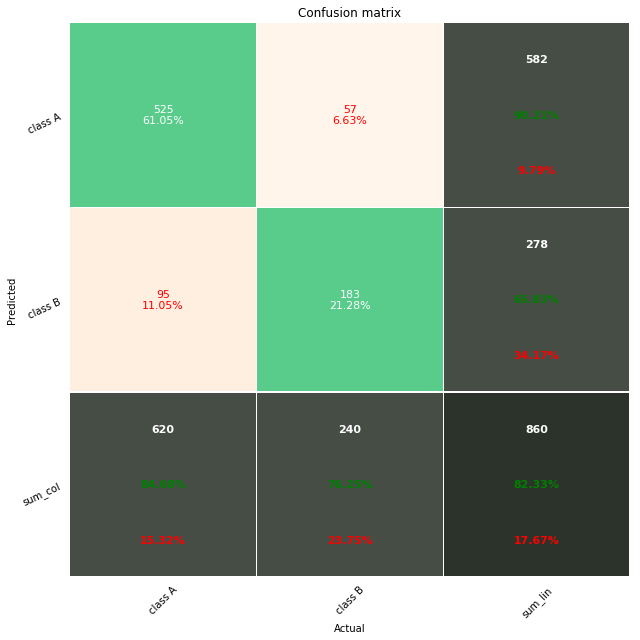

In [23]:
from visualization.confusion_matrix_pretty_print import plot_confusion_matrix_from_data

columns = []
annot = True
cmap = 'Oranges'
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
# size::
fz = 12;
figsize = [9, 9];
if len(y_test) > 10:
    fz = 9;
    figsize = [14, 14];
plot_confusion_matrix_from_data(test["subtask_a"], test['predictions'], columns,
                                    annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

### Accuracy

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(test["subtask_a"], test['predictions'])

0.8232558139534883